In [2]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Load the dataset
dataset_path = "/Users/jell15/Downloads/archive/Wafer_Map_Datasets.npz"  # Update with your dataset path
data = np.load(dataset_path)

# Extract features and labels
X = data['arr_0']  # Feature data (e.g., images)
y = data['arr_1']  # Labels (e.g., class indices)

# Normalize feature data to range [0, 1]
X = X / 255.0

# Ensure feature data has the correct shape
X = X.reshape(-1, X.shape[1], X.shape[2], 1)  # Ensure (num_samples, 52, 52, 1)

# Verify shapes
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (38015, 52, 52, 1)
y shape: (38015, 8)


In [4]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
# Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert one-hot encoded labels to integer indices
y_train = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)
y_val = torch.tensor(np.argmax(y_val, axis=1), dtype=torch.long)
y_test = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)

# Convert feature data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # From (N, H, W, C) to (N, C, H, W)
X_val = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Verify DataLoader
for inputs, labels in train_loader:
    print("Batch X shape:", inputs.shape)
    print("Batch y shape:", labels.shape)
    break

Batch X shape: torch.Size([64, 1, 52, 52])
Batch y shape: torch.Size([64])


In [ ]:
# Define the CNN architecture
class WaferMapCNN(nn.Module):
    def __init__(self, num_classes):
        super(WaferMapCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)  # Grayscale input
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Additional convolution
        self.fc1 = nn.Linear(128 * 6 * 6, 128)  # Adjust for 6x6 feature map after pooling
        self.fc2 = nn.Linear(128, num_classes)  # Output layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv3(x)))  # Conv3 -> ReLU -> Pool
        x = x.view(-1, 128 * 6 * 6)  # Flatten feature maps to a vector
        x = F.relu(self.fc1(x))  # Fully connected -> ReLU
        x = self.fc2(x)  # Output layer
        return x

# Initialize the model
num_classes = len(np.unique(y))  # Number of unique classes in your dataset
model = WaferMapCNN(num_classes=8)
print(model)

WaferMapCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [8]:
# Check the number of classes
num_classes = torch.unique(y_train).numel()
print(f"Number of classes in the dataset: {num_classes}")

# Define the model
model = WaferMapCNN(num_classes=num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
train_losses = []
train_accuracies = []
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Compute average loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

Number of classes in the dataset: 8
Epoch 1/20, Loss: 1.5780, Accuracy: 0.3593
Epoch 2/20, Loss: 1.5688, Accuracy: 0.3597
Epoch 3/20, Loss: 1.5678, Accuracy: 0.3643
Epoch 4/20, Loss: 1.5668, Accuracy: 0.3660
Epoch 5/20, Loss: 1.0543, Accuracy: 0.5708
Epoch 6/20, Loss: 0.3944, Accuracy: 0.8376
Epoch 7/20, Loss: 0.2853, Accuracy: 0.8840
Epoch 8/20, Loss: 0.2292, Accuracy: 0.9091
Epoch 9/20, Loss: 0.2105, Accuracy: 0.9167
Epoch 10/20, Loss: 0.2133, Accuracy: 0.9198
Epoch 11/20, Loss: 0.1613, Accuracy: 0.9372
Epoch 12/20, Loss: 0.1471, Accuracy: 0.9449
Epoch 13/20, Loss: 0.1352, Accuracy: 0.9499
Epoch 14/20, Loss: 0.1261, Accuracy: 0.9540
Epoch 15/20, Loss: 0.1210, Accuracy: 0.9560
Epoch 16/20, Loss: 0.1008, Accuracy: 0.9639
Epoch 17/20, Loss: 0.1104, Accuracy: 0.9597
Epoch 18/20, Loss: 0.0932, Accuracy: 0.9667
Epoch 19/20, Loss: 0.0832, Accuracy: 0.9698
Epoch 20/20, Loss: 0.0824, Accuracy: 0.9710


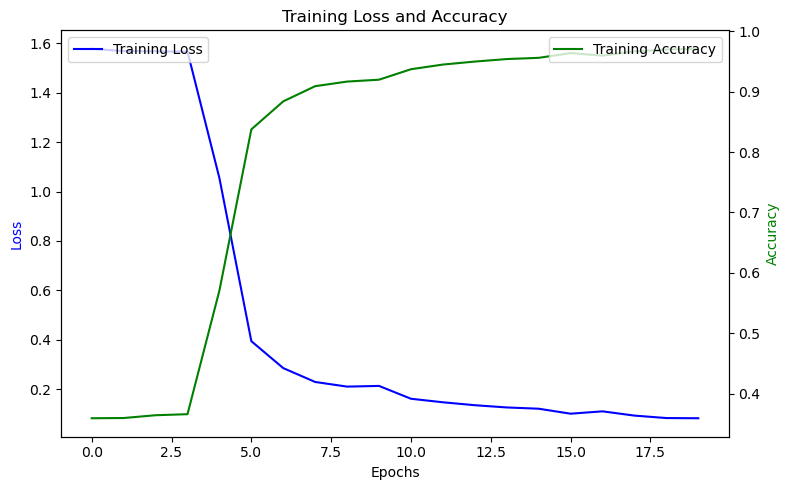

In [9]:
# Create a figure
plt.figure(figsize=(8, 5))

# Plot Training Loss
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss', color='blue')
plt.title('Training Loss and Accuracy')
plt.legend(loc='upper left')

# Create a second y-axis for accuracy
plt.twinx()  # Overlay the second y-axis
plt.plot(train_accuracies, label='Training Accuracy', color='green')
plt.ylabel('Accuracy', color='green')
plt.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

In [31]:
from sklearn.metrics import classification_report

# Initialize test loss and predictions
test_loss = 0.0
correct = 0
total = 0

all_labels = []
all_predictions = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)

        # Compute the loss for the current batch
        loss = criterion(outputs, labels)
        test_loss += loss.item()  # Accumulate the loss

        # Compute predictions
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store all labels and predictions for classification report
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate average test loss
test_loss /= len(test_loader) 

# Calculate test accuracy
test_accuracy = correct / total

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate and print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions))


Test Loss: 0.1066
Test Accuracy: 0.9572

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2131
           1       0.99      1.00      1.00      1745
           2       0.87      0.77      0.82       611
           3       0.83      0.99      0.90       597
           4       0.92      0.86      0.89       328
           5       1.00      0.86      0.93        22
           6       0.94      0.82      0.88       140
           7       0.97      0.95      0.96       129

    accuracy                           0.96      5703
   macro avg       0.94      0.91      0.92      5703
weighted avg       0.96      0.96      0.96      5703



In [21]:
# Save the state dictionary of the trained CNN model
torch.save(model.state_dict(), "cnn_model.pth")
print("CNN model saved as 'cnn_model.pth'")

CNN model saved as 'cnn_model.pth'
